## The Reissner-Nordström Metric


$$ds^2 = -c^2\left(1-\frac{r_s}{r}+\frac{r_Q^2}{r^2}\right)c^2dt^2 + \left(1-\frac{r_s}{r}+\frac{r_Q^2}{r^2}\right)^{-1}dr^2 + r^2(d\theta^2 + \sin^2\theta d\varphi^2)$$

where $r_s = \frac{2GM}{c^2}$ is the Schwarzchild's radius with $M$ is the mass of the central object and $r_Q^2 = \frac{GQ^2}{4\pi\varepsilon_0 c^4}$.

### The Geodesic Equation

The geodesic equation is:

$$\frac{d^2x^\mu}{d\lambda^2} + \Gamma^\mu_{\alpha\beta}\frac{dx^\alpha}{d\lambda}\frac{dx^\beta}{d\lambda} = 0$$

where $\Gamma^\mu_{\alpha\beta}$ are the Christoffel symbols and $\lambda$ is an affine parameter.

For the Schwarzschild metric, we can use the conserved quantities:
- Energy per unit mass: $E = \left(1-\frac{r_s}{r}+\frac{r_Q^2}{r^2}\right)c^2\frac{dt}{d\lambda}$
- Angular momentum per unit mass: $L = r^2\sin^2\theta\frac{d\phi}{d\lambda}$
- We will take $\theta = \frac{\pi}{2}$.

The equation of motion for $r$ is then :
$$-\varepsilon c^2 = - \frac{E^2}{c^2\left(1-\frac{r_s}{r}+\frac{r_Q^2}{r^2}\right)} + \frac{\frac{dr}{d\lambda}^2}{\left(1-\frac{r_s}{r}+\frac{r_Q^2}{r^2}\right)}+\frac{L^2}{r^2}$$
with $\varepsilon = 0$ for massless particles and $1$ for massive particles. Let us rewrite it as :

$$\frac{dr}{d\lambda}^2 = \frac{E^2}{c^2} - c^2\left(1-\frac{r_s}{r}+\frac{r_q^2}{r^2}\right)\left(\varepsilon + \frac{L^2}{c^2r^2}\right)$$

By denoting $x= \frac{r_s}{r}$, reparametrizing $x$ to be a function of $\varphi$, $L$ and $E$ are made dimensionless and $\alpha = \frac{r_Q}{r_s}$ :
$$L^2 x'^2 = E^2-\varepsilon +\varepsilon x - x^2\left(L^2+\varepsilon\alpha^2\right) + L^2 x^3 - \alpha^2L^2x^4$$

Differentiating wrt $\varphi$:
$$2\left(L^2 x'' + \left(L^2+\varepsilon\alpha^2\right)x\right) = \varepsilon + 3L^2x^2 - 4\alpha^2 L^2x^3.$$

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as sci
import scipy.optimize as sco

Let us implement the resolution of the equation :

In [83]:
def geodesic_equation(state, l, epsilon, alpha):
    """
    The geodesic equation

    Parameters :
    ----------
    state : [x, x_prime]
    l : dimensionless angular momentum as defined in the last differential equation
    epsilon : 0 for massless particules, 1 for massive particles
    alpha : ratio between r_Q and r_s as defined in the last differential equation

    Returns :
    -------
    x_prime, x_pprime : the first and second derivatives
    """
    #State
    x, x_prime = state
        
    # Second derivative
    x_double_prime = -(1+epsilon*alpha**2/l**2)*x + epsilon/(2*l**2) + 3*x**2/2 - 2*alpha**2*x**3
        
    return [x_prime, x_double_prime]
    
def solve_geodesic(x0, x_prime0, l, epsilon, alpha, n_revol, n_points):
    """
    Solve the geodesic equation

    Parameters :
    ----------
    x0 : initial value of x
    x_prime0 : initial value of x_prime0
    l : dimensionless angular momentum as defined in the last differential equation
    epsilon : 0 for massless particules, 1 for massive particles
    alpha : ratio between r_Q and r_s as defined in the last differential equation
    n_revol : number of revolutions in the solution
    n_points : number of evaluations of the solution
    """
    #Initial state
    initial_state = [x0, x_prime0]
        
    # Solve the ODE
    solution = sci.solve_ivp(
        lambda t, y: geodesic_equation(y, l, epsilon, alpha),
        [0, n_revol*2*np.pi],
        initial_state,
        method='RK45',
        t_eval = np.linspace(0, n_revol*2*np.pi, n_points),
        dense_output = True,
        rtol=1e-12,
        atol=1e-12
    )
        
    return solution
    
def plot_geodesic(solution):
    """Plot the geodesic (r/r_s) in polar coordinates."""
    x = solution.y[0]
    phi = solution.t

    mask = x > 0
    x = x[mask]
    phi = phi[mask]

    r = 1/x
    
    #Convert to Cartesian coordinates for plotting
    x_cart = r * np.cos(phi)
    y_cart = r * np.sin(phi)
        
    fig, ax = plt.subplots(figsize=(10, 8))
        
    #Plot the central mass (black hole)
    event_horizon = plt.Circle((0, 0), 1, color='black', fill=True)
    ax.add_artist(event_horizon)
        
    # Plot the trajectory
    ax.plot(x_cart, y_cart, 'r-', label='Geodesic')
    ax.plot(x_cart[0], y_cart[0], 'go', label='Start')
    ax.plot(x_cart[-1], y_cart[-1], 'bo', label='End')
        
    # Set equal aspect ratio
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')
    #ax.set_title(title)
    ax.legend()
        
    # Set limits based on the trajectory
    max_range = max(np.max(np.abs(x_cart)), np.max(np.abs(y_cart)))
    ax.set_xlim(-max_range*1.1, max_range*1.1)
    ax.set_ylim(-max_range*1.1, max_range*1.1)
        
    plt.show()

#### Precession of orbits as a function of the charge 

In [84]:
def precession(sol):
    """
    Calculate the precession of an orbit

    Parameters:
    ----------
    sol : solution of the geodesic equation as given by solve_geodesic

    Returns:
    The angular difference (modulo 2pi) between two successive periastron
    """
    phi = sol.t
    r = sol.y[0]
    drdphi = sol.y[1]

    zero_crossings = []
    for i in range(len(drdphi) - 1):
        if drdphi[i] >= 0 and drdphi[i+1] < 0:
            zero_crossings.append(i)

    precise_phi = []
    for i in zero_crossings:
        def f(phi_interp):
            return sol.sol(phi_interp)[1]
        try:
            root = sco.brentq(f, phi[i], phi[i+1])
            precise_phi.append(root)
        except ValueError:
            continue
    diff = precise_phi[1] - precise_phi[0] - 2*np.pi
    return diff

Let us try to solve the geodesic equation for an orbit with parameters wisely chosen (They respect the approximation made in calculations and they are not too small for the computations of the code).

We will try an orbit defined at first order by : $x = \frac{1}{p}\left(1+e\cos\left(\varphi\right)\right)$

In [85]:
e = 0.2 
p = 4000

x_0 = (1+e)/p
L = np.sqrt(p/2)

sol_1 = solve_geodesic(x_0, 0, L, 1, 0, 1.5, 10**7)

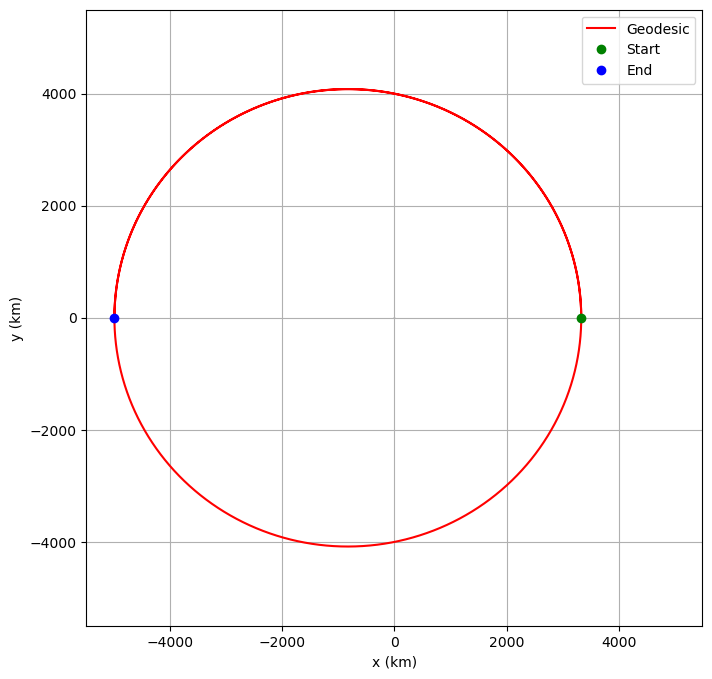

In [86]:
plot_geodesic(sol_1)

In [87]:
precession(sol_1)

0.002358409420100571

In [88]:
3*np.pi/(2*L**2)

0.0023561944901923444

The calculated and expected precession are really close.

Let us do the implementation for a charged star :
The precession is expected to be : $\Delta \varphi = \frac{3\pi}{p} - \frac{\pi\alpha^2}{L^2}$ with $p = 2L^2$.

In [89]:
alpha = np.linspace(0, 1/2, 500)
prec = []

for a in alpha:
    sol = solve_geodesic(x_0, 0, L, 1, a, 2, 10**5)
    prec.append(precession(sol))

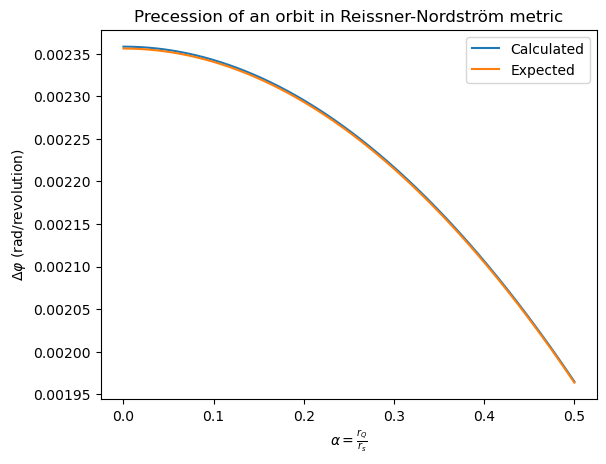

In [90]:
plt.plot(alpha, prec, label='Calculated')
plt.plot(alpha, 3*np.pi/(2*L**2)- np.pi*alpha**2/L**2, label='Expected')
plt.legend()
plt.xlabel(r'$\alpha = \frac{r_Q}{r_s}$')
plt.ylabel(r'$\Delta \varphi$ (rad/revolution)')
plt.title('Precession of an orbit in Reissner-Nordström metric')
plt.show()

#### Deviation of light 

In [91]:
def deviation(solution):
    x = solution.y[0]
    phi = solution.t

    mask = x > 0
    x = x[mask]
    phi = phi[mask]

    return np.pi - phi[-1] + phi[0]

In [92]:
x_00 = 0
x_prime00 = 1/100

sol_2 = solve_geodesic(x_00, x_prime00, 1, 0, 0, 1, 10**7)

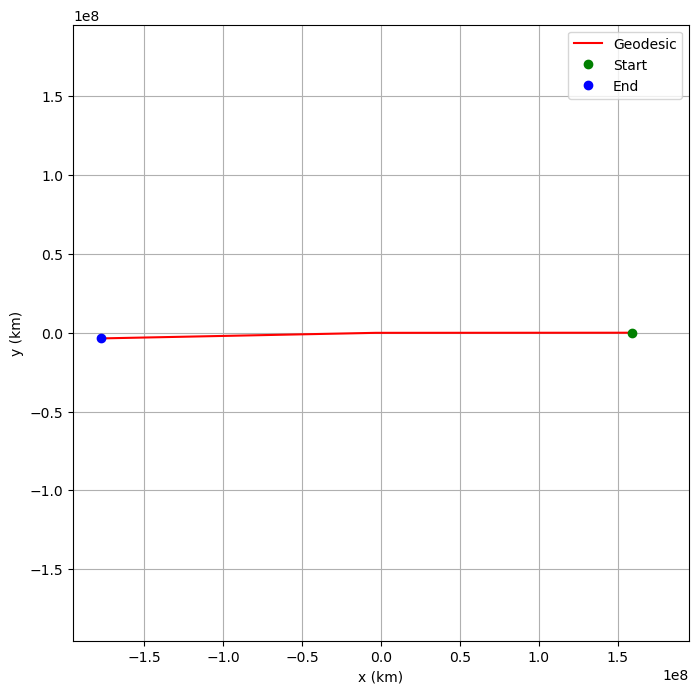

In [93]:
plot_geodesic(sol_2)

In [94]:
deviation(sol_2)

-0.02029877464251722

The deviation is expected to be : $\chi = -\frac{2}{b} + \frac{3\pi\alpha^2}{2b^2}$ with $b$ the impact parameter.

In [95]:
dev = []

for a in alpha:
    sol = solve_geodesic(x_00, x_prime00, 1, 0, a, 1, 10**7)
    dev.append(deviation(sol))

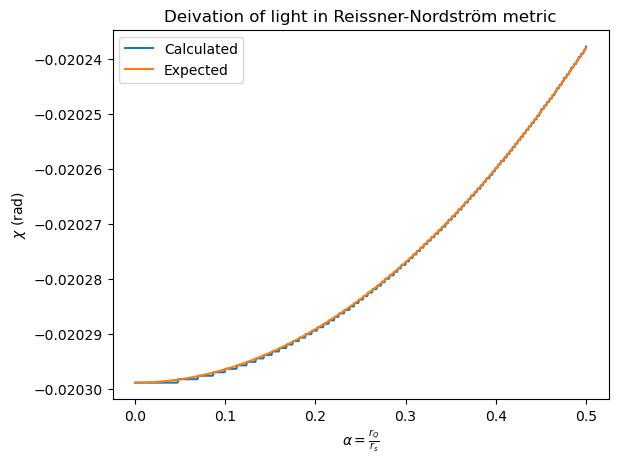

In [96]:
b = -2/deviation(sol_2)
chi = -2/b + np.pi/b**2*(3*alpha**2/4)

plt.plot(alpha, dev, label='Calculated')
plt.plot(alpha, chi, label='Expected')
plt.legend()
#plt.ylim(-0.025, -0.015)
plt.xlabel(r'$\alpha = \frac{r_Q}{r_s}$')
plt.ylabel(r'$\chi$ (rad)')
plt.title('Deivation of light in Reissner-Nordström metric')
plt.show()

## The Entangled Relativity Metric

The ER metric is given by:

$$ds^2 = -\lambda_0 c^2dt^2 + \frac{1}{\lambda_r}dr^2 + h\left(d\theta^2 + \sin^2\theta d\varphi^2\right)$$

where :
$$\lambda_0 = \left(1-\frac{r_+}{r}\right)\left(1-\frac{r_-}{r}\right)^{\frac{15}{13}}$$
$$\lambda_r = \left(1-\frac{r_+}{r}\right)\left(1-\frac{r_-}{r}\right)^{\frac{7}{13}}$$
$$h = r^2\left(1-\frac{r_-}{r}\right)^{\frac{6}{13}}$$

and $u$ and $v$ are related to the mass and the charge of the central object via :
$$\frac{2GM}{c^2}=r_s = r_+ + \frac{11}{13}r_-$$
$$\frac{GQ^2}{4\pi\epsilon_0c^4} =r_Q^2= \frac{12}{13}r_+r_-$$

The scalar field is given by :
$$\phi = \frac{1}{\left(1-\frac{r_-}{r}\right)^{\frac{2}{13}}}$$

### The Modified Geodesic Equation

The geodesic equation is:

$$\frac{d^2x^\mu}{d\lambda^2} + \Gamma^\mu_{\alpha\beta}\frac{dx^\alpha}{d\lambda}\frac{dx^\beta}{d\lambda} = -\left(g^{\mu\nu}+\frac{dx^\mu}{d\lambda}\frac{dx^\nu}{d\lambda}\right)\frac{\partial_\nu \phi}{\phi}$$

where $\Gamma^\mu_{\alpha\beta}$ are the Christoffel symbols and $\lambda$ is an affine parameter.

For the solution of these equations, we can use the conserved quantities:
- Energy per unit mass: $\frac{E}{m} = c^2\lambda_0\phi\frac{dt}{d\lambda}$
- Angular momentum per unit mass: $\frac{L}{m} = h\phi\frac{d\phi}{d\lambda}$
- We will take $\theta = \frac{\pi}{2}$.

The equation of motion is :
$$\frac{dr}{d\lambda}^2 = \frac{\lambda_r}{\phi^2\lambda_0}\frac{E^2}{m^2c^2} - c^2\lambda_r\left(\varepsilon+\frac{L^2}{\phi^2h m^2c^2}\right)$$

After simplifying :
$$\frac{dr}{d\lambda}^2 = \left(1-\frac{v}{r}\right)^{-\frac{4}{13}}\frac{E^2}{m^2c^2} - c^2\left(1-\frac{u}{r}\right)\left(1-\frac{v}{r}\right)^{\frac{7}{13}} \left(\varepsilon+\frac{L^2}{r^2 \left(1-v/r\right)^{\frac{2}{13}} m^2c^2}\right)$$
$$\left(\left(1-\frac{v}{r}\right)^{\frac{2}{13}}\frac{dr}{d\lambda}\right)^2 = \frac{E^2}{m^2c^2} - c^2\left(1-\frac{u}{r}\right)\left(1-\frac{v}{r}\right)^{\frac{11}{13}} \left(\varepsilon+\frac{L^2}{r^2 \left(1-v/r\right)^{\frac{2}{13}} m^2c^2}\right)$$

Following the same steps and using the same notation as in the GR case, we obtain this equation :
$$L^2 x'^2 \left(1-vx\right)^{-\frac{4}{13}} = E^2 - \left(1-ux\right)\left(1-vx\right)^\frac{11}{13}\left(\varepsilon+L^2x^2\left(1-vx\right)^{-\frac{2}{13}}\right)$$
where $x = \frac{r_s}{r}$, $u = \frac{r_+}{r_s}$ and $v = \frac{r_-}{r_s}$

In [97]:
def er_equation(state, L, epsilon, u, v):
    """
    The modified geodesic equation in ER

    Parameters :
    ----------
    state : [x, x_prime]
    l : dimensionless angular momentum as defined in the last differential equation
    epsilon : 0 for massless particules, 1 for massive particles
    alpha : ratio between r_Q and r_s as defined in the last differential equation
    u, v : dimensionless paramters of the metric
    
    Returns :
    -------
    x_prime, x_double_prime : the first and second derivatives
    """

    x, x_prime = state

    a = 1-u*x
    b = 1-v*x
    
    # Second derivatives
    A = 2*v*x_prime**2/(13*b)
    B = u*b**(15/13)/(2*L**2)*(epsilon + L**2*(x**2*b**(-2/13)))
    C = 11*v*a/(26*L**2)*b**(2/13)*(epsilon + L**2*(x**2*b**(-2/13)))
    D = a*x*(b+x*v/(13*b**(8/13)))
    
    x_double_prime = -A+B+C-D
        
    return [x_prime, x_double_prime]
    
def solve_er(x0, x_prime0, L, epsilon, alpha, n_revol, n_points):
    """
    Solve the geodesic equation

    Parameters :
    ----------
    x0 : initial value of x
    x_prime0 : initial value of x_prime0
    l : dimensionless angular momentum as defined in the last differential equation
    epsilon : 0 for massless particules, 1 for massive particles
    alpha : ratio between r_Q and r_s as defined in the last differential equation
    n_revol : number of revolutions in the solution
    n_points : number of evaluations of the solution
    """
    
    u = (1+np.sqrt(1-11*alpha**2/3))/2
    v = (13/11)*(1-np.sqrt(1-11*alpha**2/3))/2

    #Initial state
    initial_state = [x0, x_prime0]  
        
    # Solve the ODE
    solution = sci.solve_ivp(
        lambda t, y: er_equation(y, L, epsilon, u, v),
        [0, n_revol*2*np.pi],
        initial_state,
        method='RK45',
        t_eval = np.linspace(0, n_revol*2*np.pi, n_points),
        dense_output = True,
        rtol=1e-10,
        atol=1e-10
    )
        
    return solution

In [98]:
prec_1 = []
e = 0.2 
p = 4000

x_0 = (1+e)/p
L = np.sqrt(p/2)

for a in alpha:
    sol = solve_er(x_0, 0, L, 1, a, 2, 10**5)
    prec_1.append(precession(sol))

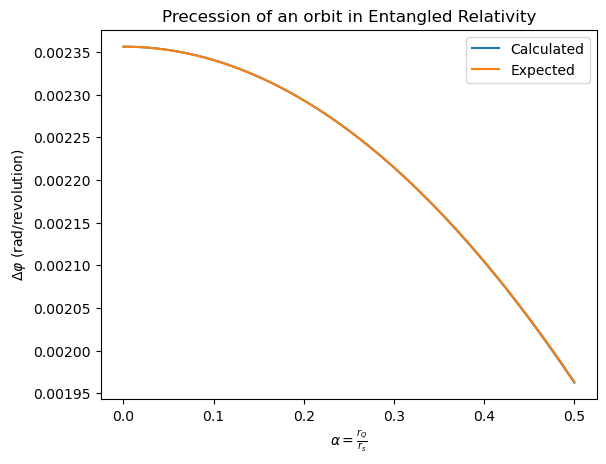

In [99]:
plt.plot(alpha, prec_1, label='Calculated')
plt.plot(alpha, 3*np.pi/(2*L**2)- np.pi*alpha**2/L**2, label='Expected')
plt.legend()
plt.xlabel(r'$\alpha = \frac{r_Q}{r_s}$')
plt.ylabel(r'$\Delta \varphi$ (rad/revolution)')
plt.title('Precession of an orbit in Entangled Relativity')
plt.show()

In [100]:
dev_1 = []
x_00 = 0
x_prime00 = 1/100

for a in alpha:
    sol = solve_er(x_00, x_prime00, 1, 0, a, 1, 10**7)
    dev_1.append(deviation(sol))

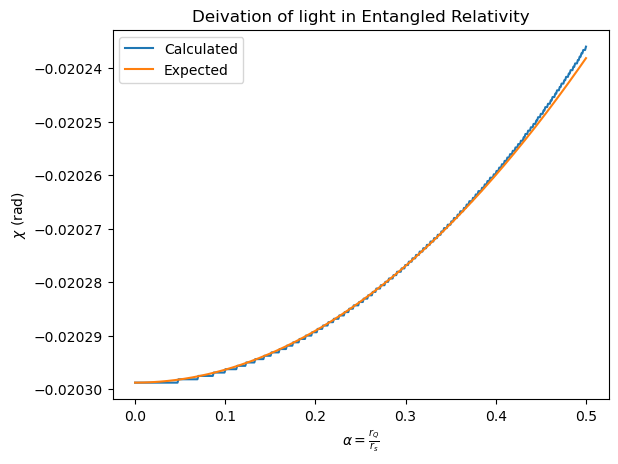

In [104]:
b = -2/deviation(sol_2)
chi = -2/b + np.pi/b**2*(3*alpha**2/4)

plt.plot(alpha, dev_1, label='Calculated')
plt.plot(alpha, chi, label='Expected')
plt.legend()
#plt.ylim(-0.025, -0.015)
plt.xlabel(r'$\alpha = \frac{r_Q}{r_s}$')
plt.ylabel(r'$\chi$ (rad)')
plt.title('Deivation of light in Entangled Relativity')
plt.show()